In [1]:
# allows to import own functions
import sys, os, re
root_project = re.findall(r'(^\S*TFM-master)', os.getcwd())[0]
sys.path.append(root_project)

from src.utils.help_func import results_searchcv, make_train_val_test, errors_distribution
from src.features.add_features import features_graph, features_pop

In [2]:
import xgboost as xgb
import pandas as pd
import networkx as nx
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, expon, randint, loguniform
import joblib

In [3]:
df_i = pd.read_pickle(f'{root_project}/data/processed/features_model_rev5.pickle')
df_i

,i_country,R0,Tc,Tr,omega,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,limit_deaths,n_closed,react_time,total_infected,total_death,total_removed,betweenness,degree,closeness,country_pop
0,LBN,9.490802,2.214174,21.014286,0.069029,2918.571429,114.077951,0.007146,0.005701,0.048225,72,6,23,7.509688e+09,5.191675e+08,7.521476e+09,0.001057,0.270270,0.460581,6848925.0
1,KIR,3.161672,6.111805,19.323523,0.012080,126501.000000,291.642242,0.003715,0.002368,0.007072,872,2,2,7.166248e+09,8.694994e+07,7.201020e+09,0.000956,0.036036,0.391534,115847.0
2,MOZ,16.439975,1.263448,20.771054,0.046275,80454.071429,2297.546954,0.002847,0.001771,0.026642,192,0,22,7.530737e+09,3.532065e+08,7.633573e+09,0.000059,0.054054,0.382759,29495962.0
3,ERI,2.141326,1.149404,2.461249,0.014779,5593.642857,196.917492,0.006883,0.009034,0.010026,511,9,28,6.401541e+09,9.461014e+07,6.402090e+09,0.000007,0.049550,0.368159,3213972.0
4,VCT,9.327237,1.192357,11.121400,0.058201,9880.857143,286.248927,0.013316,0.013809,0.044225,958,18,20,7.477989e+09,4.352523e+08,7.478614e+09,0.000035,0.040541,0.312236,110210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279990,SGP,18.473903,1.031939,19.063932,0.867346,17242.500000,8752.775510,0.047399,0.026678,0.453940,183,9,7,7.503800e+09,6.508834e+09,7.504311e+09,0.013456,0.360360,0.509174,5638676.0
279991,CIV,15.657956,0.799619,12.520400,0.965765,85400.000000,49171.770833,0.062628,0.031725,0.448804,63,15,4,2.503739e+07,2.418014e+07,2.503729e+07,0.000908,0.166667,0.419660,25069229.0
279992,ARE,3.729777,3.696492,13.787093,0.619548,28.642857,11.933333,0.152120,0.170391,0.465649,110,3,5,1.121218e+07,6.946411e+06,1.121216e+07,0.055779,0.806306,0.608219,9630959.0
279993,LAO,7.372083,1.849250,13.632825,0.701566,378.928571,217.193548,0.094251,0.074261,0.473037,496,11,8,6.538427e+09,4.590038e+09,6.542575e+09,0.000000,0.063063,0.375635,7061507.0


In [4]:
features = ['Tr', 'inf_pow_1', 'inf_pow_2', 'mort_pow_1', 'mort_pow_2', 'mort_pow_3', 'limit_deaths',
           'n_closed', 'react_time','total_death', 'betweenness', 'degree', 'closeness', 'country_pop']

df = df_i[features]

# df_model = df_model.sample(30000) # par entrenar con menos muestras
size_data = int(len(df) / 1000)
print(size_data)
df

279


,Tr,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,limit_deaths,n_closed,react_time,total_death,betweenness,degree,closeness,country_pop
0,21.014286,2918.571429,114.077951,0.007146,0.005701,0.048225,72,6,23,5.191675e+08,0.001057,0.270270,0.460581,6848925.0
1,19.323523,126501.000000,291.642242,0.003715,0.002368,0.007072,872,2,2,8.694994e+07,0.000956,0.036036,0.391534,115847.0
2,20.771054,80454.071429,2297.546954,0.002847,0.001771,0.026642,192,0,22,3.532065e+08,0.000059,0.054054,0.382759,29495962.0
3,2.461249,5593.642857,196.917492,0.006883,0.009034,0.010026,511,9,28,9.461014e+07,0.000007,0.049550,0.368159,3213972.0
4,11.121400,9880.857143,286.248927,0.013316,0.013809,0.044225,958,18,20,4.352523e+08,0.000035,0.040541,0.312236,110210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279990,19.063932,17242.500000,8752.775510,0.047399,0.026678,0.453940,183,9,7,6.508834e+09,0.013456,0.360360,0.509174,5638676.0
279991,12.520400,85400.000000,49171.770833,0.062628,0.031725,0.448804,63,15,4,2.418014e+07,0.000908,0.166667,0.419660,25069229.0
279992,13.787093,28.642857,11.933333,0.152120,0.170391,0.465649,110,3,5,6.946411e+06,0.055779,0.806306,0.608219,9630959.0
279993,13.632825,378.928571,217.193548,0.094251,0.074261,0.473037,496,11,8,4.590038e+09,0.000000,0.063063,0.375635,7061507.0


In [5]:
X_train_val, y_train_val, X_test, y_test = make_train_val_test(df, out_mode=1)
# X = df_model.drop('total_death', axis=1)
# y = df_model['total_death']

# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train_validation set: (223996, 13)
Test set: (55999, 13)


In [6]:
param_dist = dict(
    max_depth=randint(low=1, high=11),
    learning_rate=loguniform(0.01, 0.1),
    subsample=uniform(loc=0.8, scale=1-0.8),
    colsample_bytree=uniform(loc=0.8, scale=1-0.8),
    gamma=[0, 1, 5]
)

# model = xgb.XGBRegressor(scale_pos_weight=1,
#                          learning_rate=0.01,
#                          colsample_bytree=0.4,
#                          subsample=0.8,
#                          n_estimators=100,
#                          reg_alpha=0.3,
#                          max_depth=4,
#                          gamma=10)

random_search = RandomizedSearchCV(xgb.XGBRegressor(), param_distributions=param_dist, verbose=2, cv=3,
                          n_iter=20, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

random_search.fit(X_train_val, y_train_val)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.1min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc52ef885b0>,
                                        'gamma': [0, 1, 5]

In [7]:
# joblib.dump(random_search, f"{root_project}/models/xgb_rev12_v.pkl")

In [8]:
# random_search = joblib.load(f"{root_project}/models/xgb_rev12.pkl")

In [10]:
results_searchcv(random_search, X_test, y_test)

Best score:
-4.000813851667438e+17
Best parameters found:
{'colsample_bytree': 0.9853317731587589, 'gamma': 5, 'learning_rate': 0.08353610755311759, 'max_depth': 8, 'subsample': 0.9140887948810799}
Score in test:
-2.848238315598226e+16
R^2 in test
0.9415247875279489
MAE in test:
91165486.50462006


In [ ]:
# param_dist = dict(
#     max_depth=randint(low=8, high=15),
#     learning_rate=loguniform(0.01, 0.1),
#     subsample=uniform(loc=0.8, scale=1-0.8),
#     colsample_bytree=uniform(loc=0.8, scale=1-0.8),
#     gamma=[0, 1, 2]
# )


# random_search_zoom = RandomizedSearchCV(xgb.XGBRegressor(), param_distributions=param_dist, verbose=2, cv=3,
#                           n_iter=50, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# random_search_zoom.fit(X_train_val, y_train_val)

In [ ]:
# joblib.dump(random_search_zoom, f"{root_project}/models/xgb_rev12_v3.pkl")

In [12]:
random_search_zoom = joblib.load(f"{root_project}/models/xgb_rev12_v3.pkl")

In [13]:
results_searchcv(random_search_zoom, X_test, y_test)

Best score:
-1.073674287566723e+17
Best parameters found:
{'colsample_bytree': 0.8900998503939086, 'gamma': 1, 'learning_rate': 0.08889667907018926, 'max_depth': 11, 'subsample': 0.9126576435691078}
Score in test:
-8.682888014784459e+16
R^2 in test
0.9677562171193098
MAE in test:
121161276.06231385


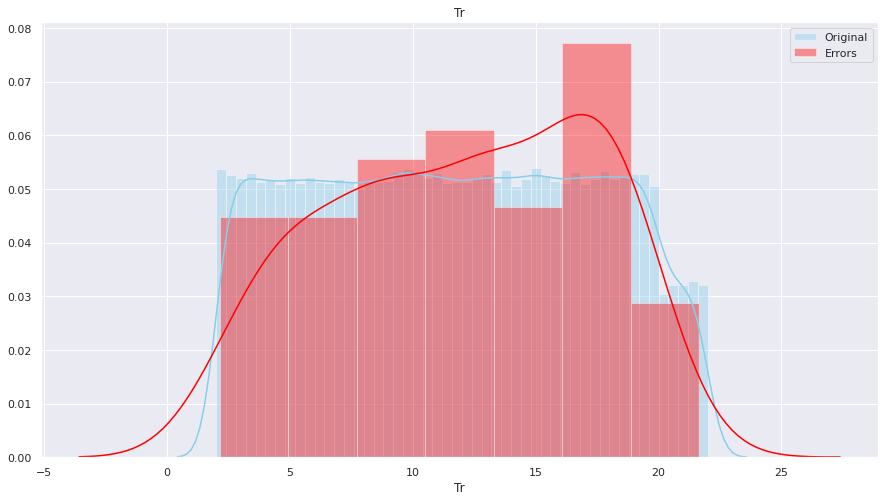

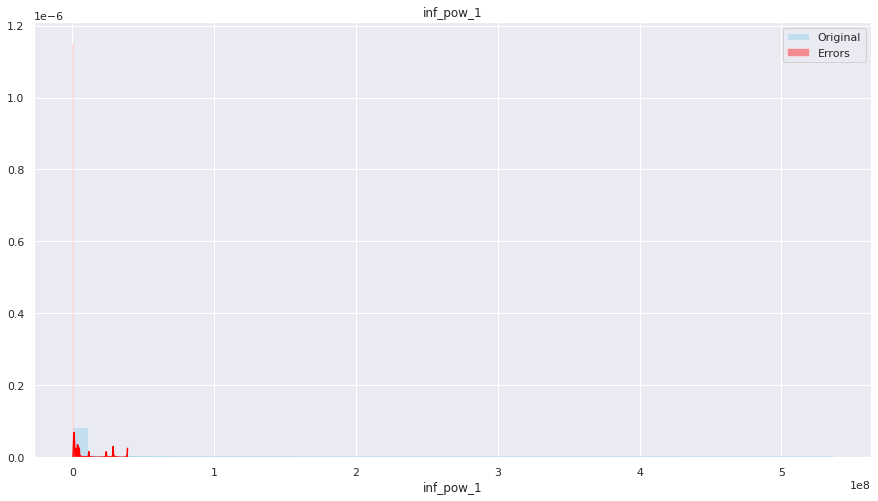

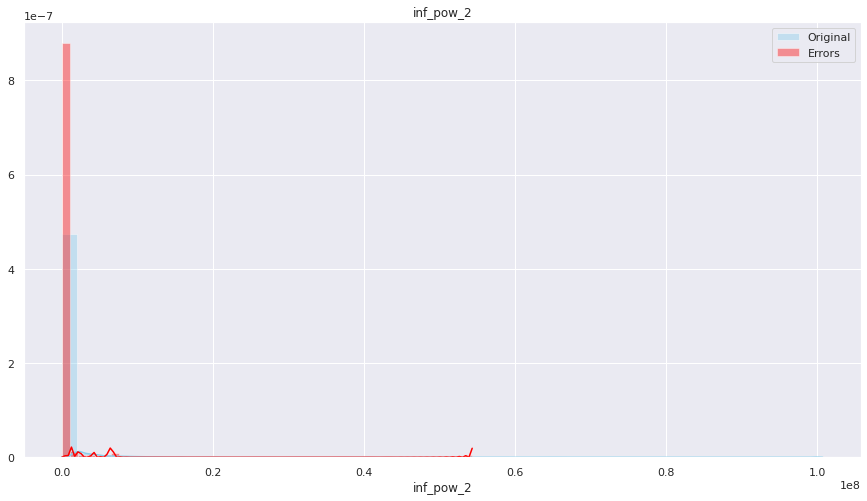

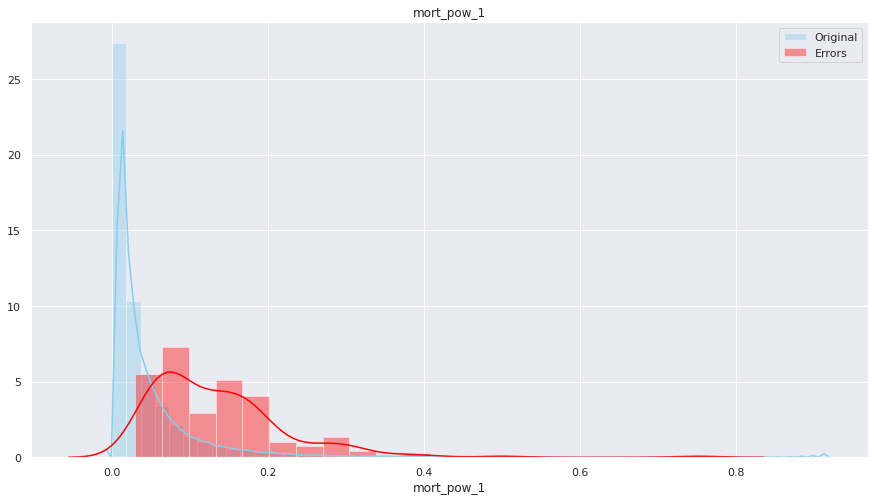

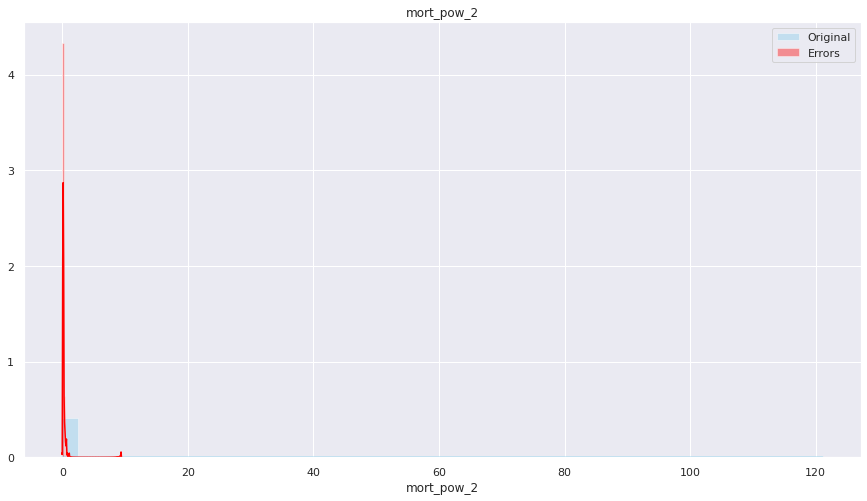

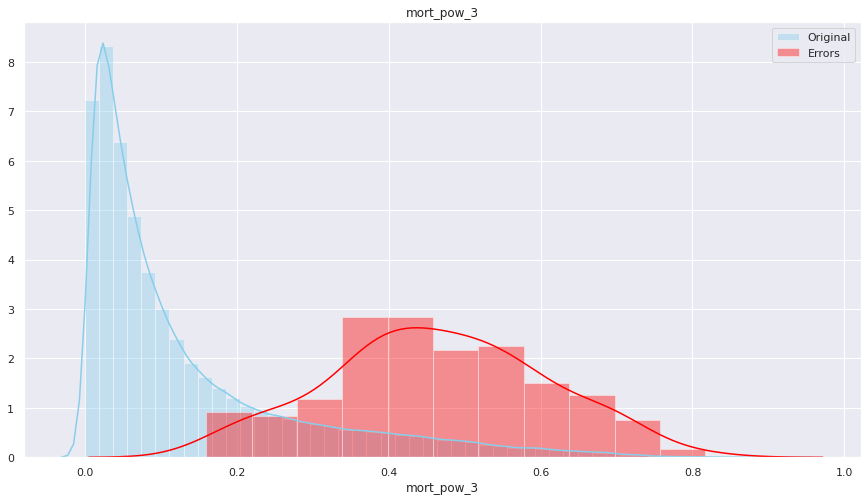

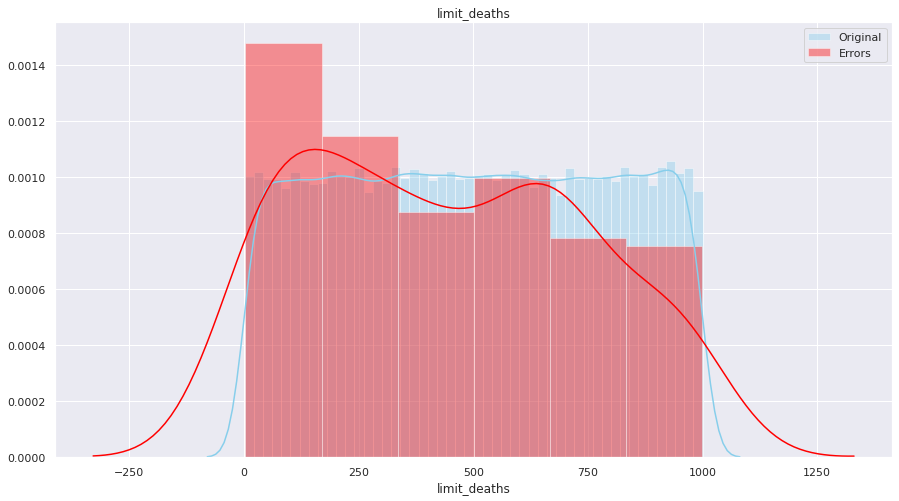

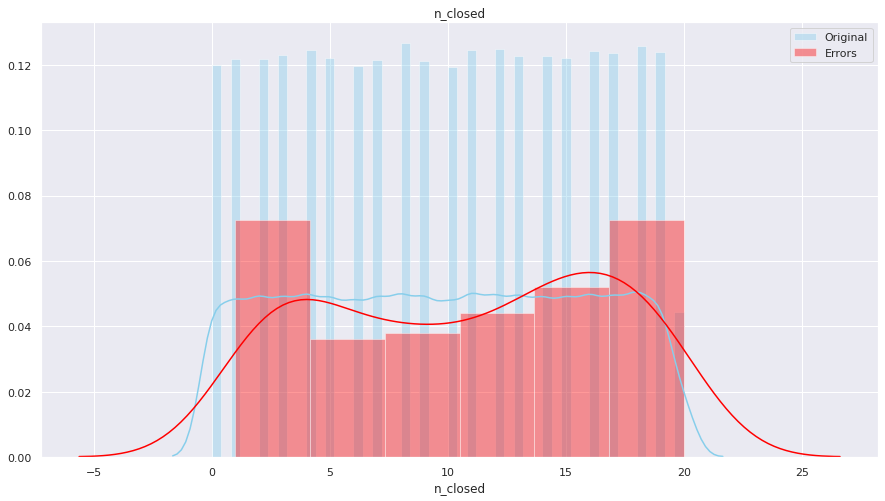

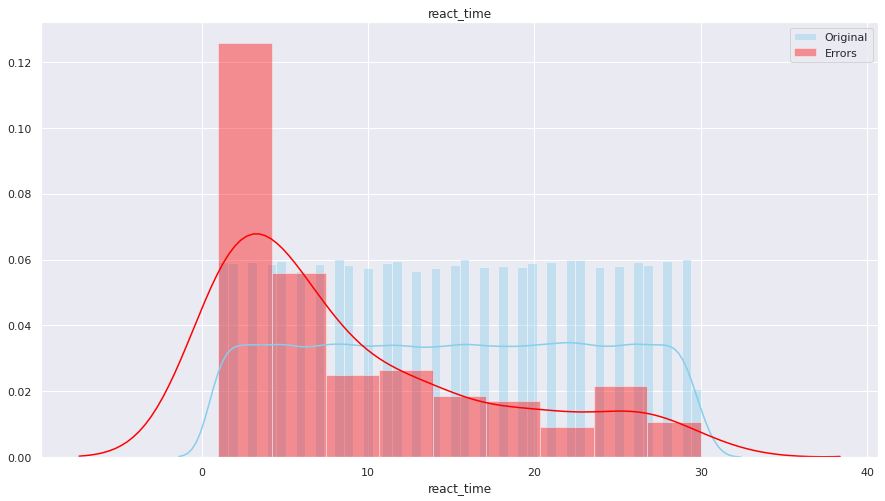

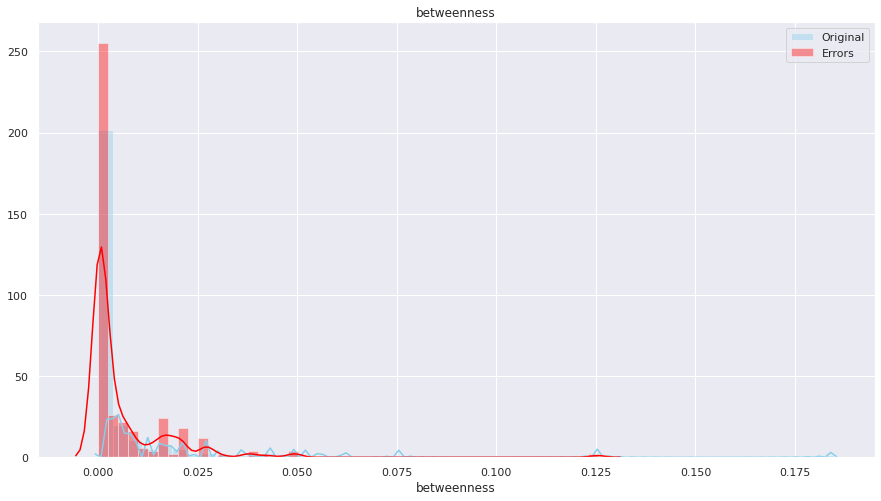

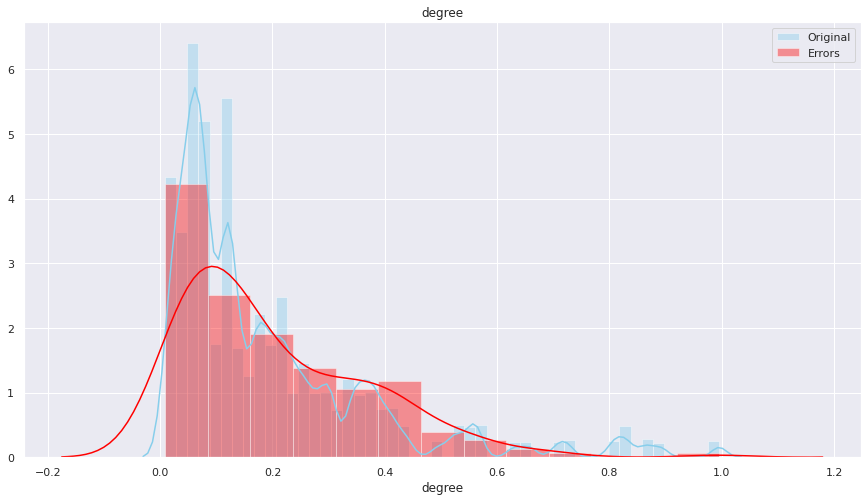

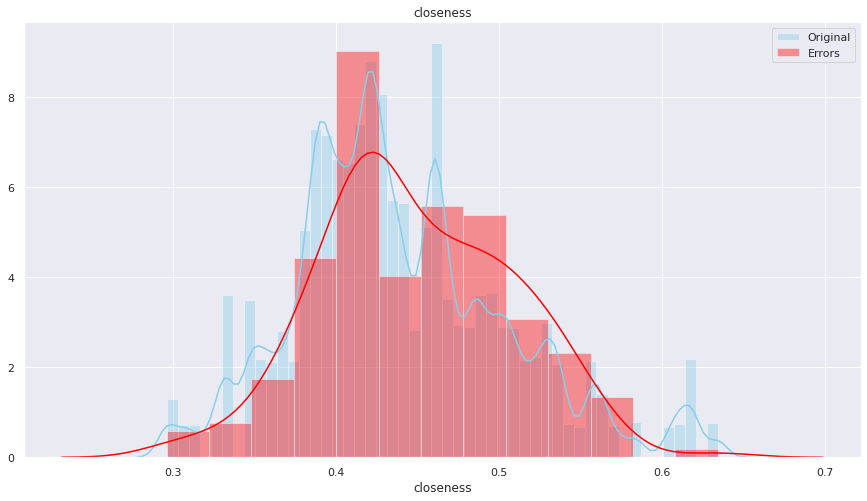

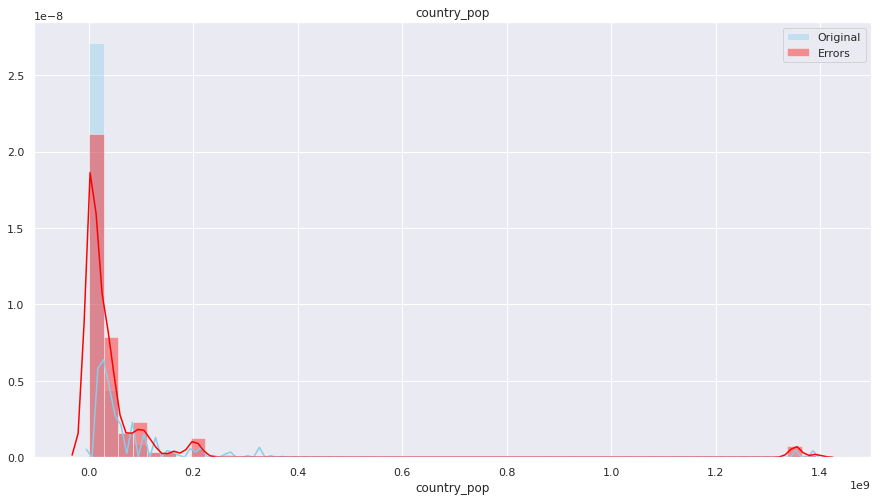

In [15]:
errors_distribution(random_search_zoom, X_test, y_test, X_train_val)

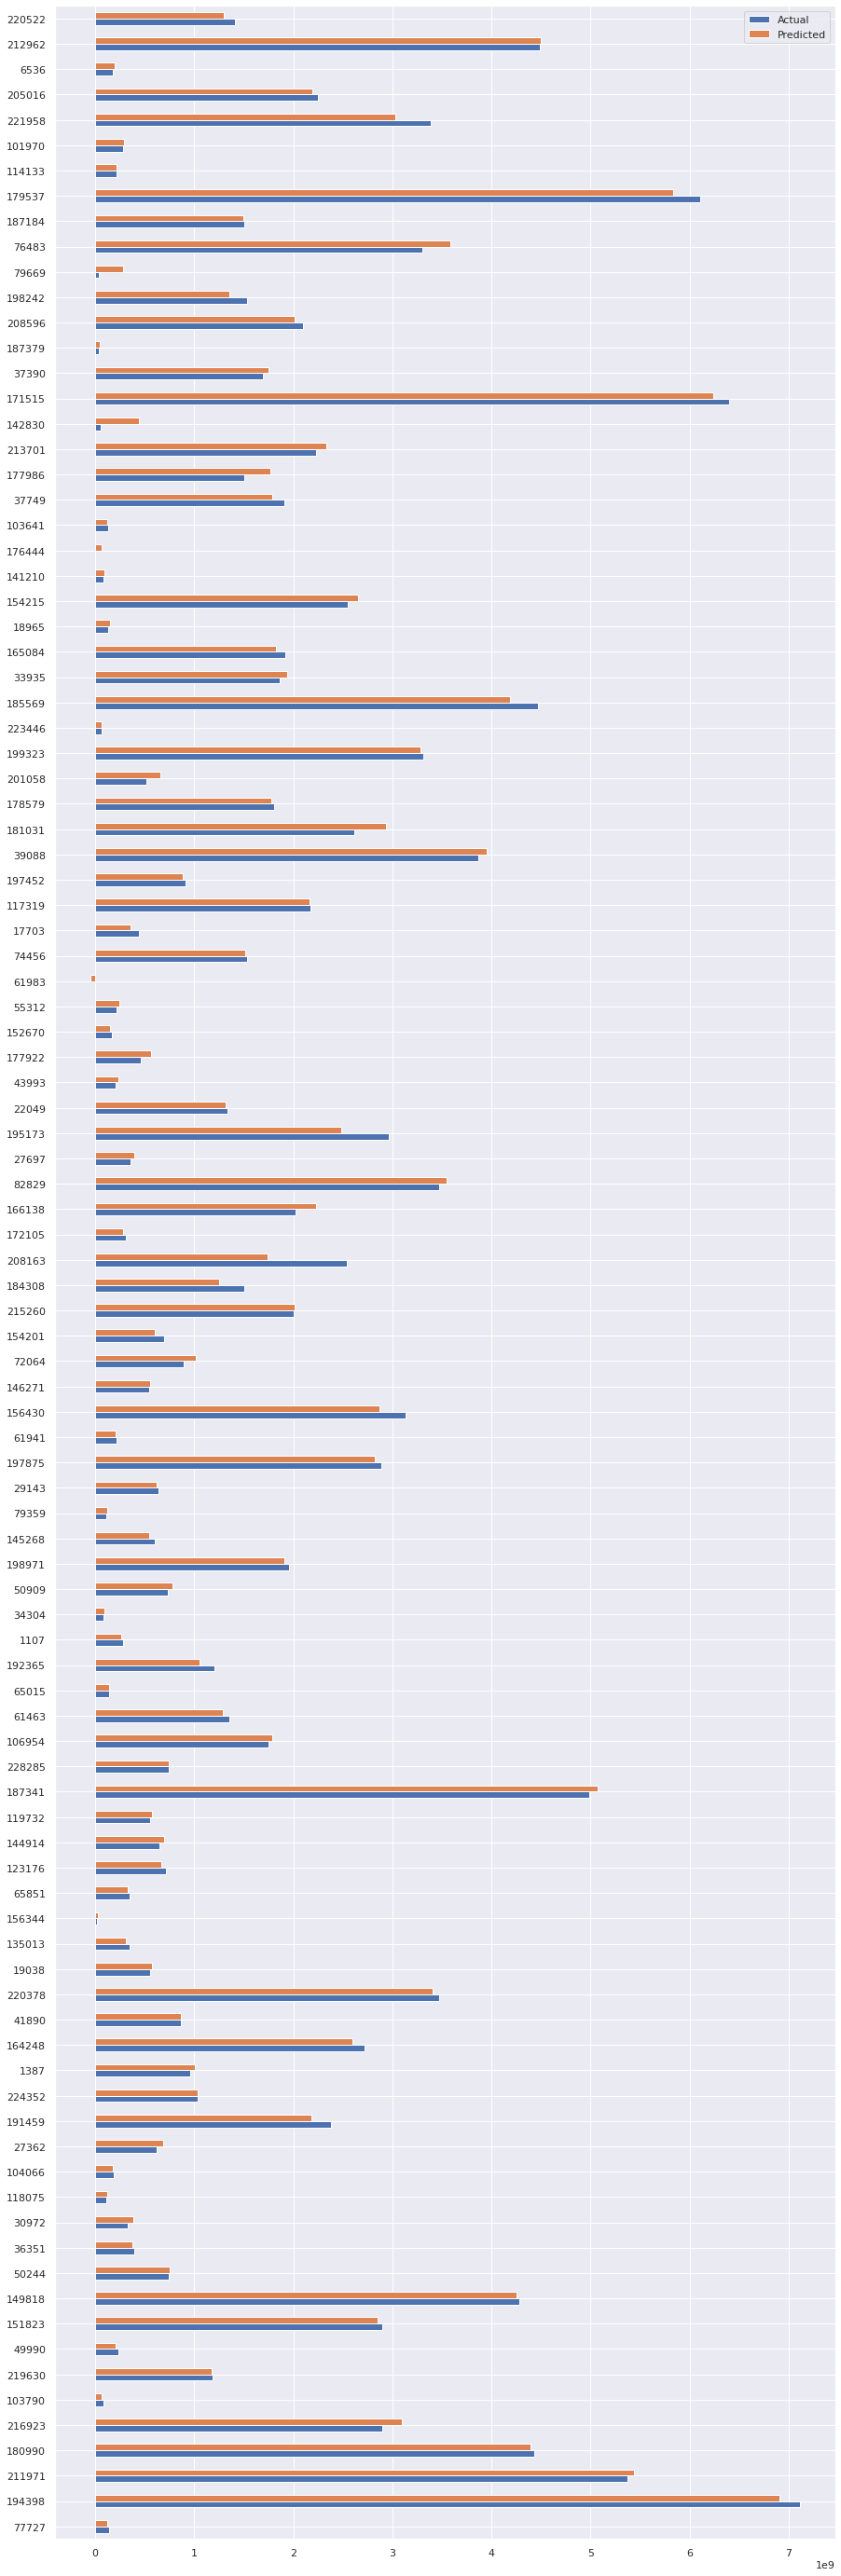

In [17]:
y_predicted = random_search_zoom.predict(X_test)
df_predicted = pd.DataFrame({'Actual': y_test, 'Predicted': y_predicted})
df_predicted.sample(100).plot(kind='barh',figsize=(15,50))
plt.show()

In [37]:
X_err = X_test.copy()
X_err['predicted'] = random_search_zoom.predict(X_test)

X_err['real'] = y_test
X_err['error'] = X_err['real'] - X_err['predicted']
X_err['abs_error'] = np.abs(X_err['error'])
X_err = X_err.sort_values(by='abs_error', ascending=False).iloc[:100]
error_idx = X_err.index

# X_err[['real', 'predicted']].plot(kind='barh', figsize=(15,20))
plt.show()

In [39]:
df_i.describe()

,R0,Tc,Tr,omega,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,limit_deaths,n_closed,react_time,total_infected,total_death,total_removed,betweenness,degree,closeness,country_pop
count,229995.000000,229995.000000,229995.000000,229995.000000,2.299950e+05,2.299950e+05,229995.000000,229995.000000,229995.000000,229995.000000,229995.000000,229995.000000,2.299950e+05,2.299950e+05,2.299950e+05,229995.000000,229995.000000,229995.000000,2.299950e+05
mean,11.665306,1.426883,11.642835,0.221008,9.868688e+06,5.031790e+05,0.039341,0.048661,0.134274,501.818261,9.715911,15.201457,6.602335e+09,1.402149e+09,6.615736e+09,0.006640,0.193516,0.439783,3.643016e+07
std,5.598334,1.374401,5.596208,0.238480,4.623592e+07,3.125646e+06,0.058139,0.439391,0.148094,288.937329,5.881560,8.487085,1.833056e+09,1.632097e+09,1.838110e+09,0.019154,0.189111,0.065701,1.374708e+08
min,2.000876,0.091932,2.000186,0.000011,2.642857e+00,8.826531e-01,0.000003,0.000003,0.000007,1.000000,0.000000,1.000000,8.991000e+03,5.310000e+02,8.992000e+03,0.000000,0.009009,0.296395,1.164600e+04
25%,6.822093,0.580697,6.812327,0.052144,2.981357e+03,2.505068e+02,0.007332,0.005541,0.032113,252.000000,5.000000,8.000000,6.146514e+09,2.919854e+08,6.210925e+09,0.000058,0.063063,0.392920,1.136191e+06
50%,11.643684,0.997416,11.616519,0.123302,6.250100e+04,3.842331e+03,0.018288,0.014895,0.074794,502.000000,10.000000,15.000000,7.502250e+09,7.426410e+08,7.503860e+09,0.000554,0.126126,0.427746,7.024216e+06
75%,16.461292,1.710664,16.438728,0.297224,8.015137e+05,4.291657e+04,0.046736,0.040155,0.179095,753.000000,15.000000,23.000000,7.512650e+09,1.826937e+09,7.515401e+09,0.003897,0.252252,0.478448,2.554982e+07
max,21.999739,10.792982,21.999318,1.278734,5.362096e+08,1.017822e+08,0.912579,121.095781,0.926599,1000.000000,20.000000,30.000000,7.582232e+09,9.689799e+09,7.665912e+09,0.184702,0.995495,0.634286,1.392730e+09


In [40]:
df_i.iloc[error_idx].describe()

,R0,Tc,Tr,omega,inf_pow_1,inf_pow_2,mort_pow_1,mort_pow_2,mort_pow_3,limit_deaths,n_closed,react_time,total_infected,total_death,total_removed,betweenness,degree,closeness,country_pop
count,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,1.000000e+02
mean,8.793878,1.926012,12.049676,0.787693,8.362781e+05,2.665200e+05,0.134895,0.139589,0.483738,457.730000,8.700000,8.200000,2.235857e+09,1.800934e+09,2.240498e+09,0.005052,0.198739,0.446146,5.713685e+07
std,4.808116,1.524942,5.128712,0.134421,4.086014e+06,1.053327e+06,0.081600,0.145840,0.145513,298.700007,5.784864,8.102874,3.001256e+09,2.457868e+09,3.008055e+09,0.008143,0.162840,0.061117,1.917101e+08
min,2.113990,0.164253,2.149643,0.480474,3.357143e+00,1.875000e+00,0.033408,0.015649,0.159578,3.000000,1.000000,1.000000,2.612950e+05,2.315600e+05,2.612930e+05,0.000000,0.009009,0.306207,1.800800e+04
25%,4.727644,0.848309,7.818870,0.683243,1.316964e+02,2.982500e+01,0.072411,0.046863,0.386060,220.000000,3.000000,2.000000,3.484885e+07,2.690816e+07,3.484881e+07,0.000066,0.072072,0.405109,4.788706e+06
50%,7.663083,1.407218,13.017062,0.802333,1.486821e+03,9.480787e+02,0.125093,0.099069,0.486389,438.000000,8.000000,5.500000,2.022686e+08,1.882065e+08,2.022686e+08,0.001156,0.157658,0.440040,1.134564e+07
75%,13.002756,2.520847,16.357896,0.890558,3.922898e+04,2.167184e+04,0.172407,0.174556,0.595745,690.250000,14.000000,11.250000,5.724759e+09,4.401207e+09,5.746572e+09,0.007007,0.315315,0.497758,3.602914e+07
max,19.470334,6.727269,19.994645,0.994311,2.866982e+07,6.603454e+06,0.404255,0.767824,0.789072,998.000000,20.000000,30.000000,7.535210e+09,7.037226e+09,7.562296e+09,0.037779,0.657658,0.564885,1.352617e+09


In [41]:
df_i.iloc[188106]

i_country                 YEM
R0                    7.67836
Tc                    1.70975
Tr                    13.1281
omega                0.989126
inf_pow_1               460.5
inf_pow_2             325.731
mort_pow_1           0.127811
mort_pow_2           0.097296
mort_pow_3            0.64933
limit_deaths              709
n_closed                    2
react_time                  6
total_infected    2.84731e+07
total_death       2.81634e+07
total_removed      2.8473e+07
betweenness       0.000564915
degree               0.144144
closeness            0.414953
country_pop       2.84987e+07
Name: 188106, dtype: object